In [100]:
#Imports and API Key
#building in offsets

#checkout scikit learn timeseries 
#checkout cross validation - rolling window

#Imports and API Key

import pandas as pd
import quandl
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier

import sys
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

%aimport dataclean

quandl.ApiConfig.api_key = 'm8FYMyoCaJSbTrBASNHh'

In [101]:
#pulling data from Quandl

data = pd.read_csv('datasources2.csv') #staging the QUANDL keys to pull in CSV
cols = list(data['Var_name'].astype('str'))
dataset = quandl.get([val for val in data['Quandl Key']]) #looping through the QUANDL keys to pull it into one DF
dataset.columns = cols

In [102]:
#pulling FED Yield Curve data

yields = pd.read_csv('Fed10Y_3M.csv')
yields['Date'] = pd.to_datetime(yields['Date'])
yields['Date'] = yields['Date'].apply(lambda x: x.strftime('%Y-%m'))
yields = yields.set_index('Date')
yields = yields.drop(['3 Month Treasury Yield', 'Rec_prob', 'NBER_Rec','Unnamed: 7'], axis=1) 

In [103]:
#need to write in special logic to factor in for 3YRT being a daily

treas = dataset['3YRT']
dataset = dataset.drop(columns = ['3YRT'])

In [104]:
treas = treas.resample('MS').mean()

In [105]:
## back to working on the general data
dataset.index = dataset.index.strftime('%Y-%m') #converting the datetime index to Y/M so it is collapsable
dataset = dataset.groupby(dataset.index, as_index=True).agg(sum) #collapsing by Y/M

In [106]:
#readd 3YRT back into data

dataset = dataset.join(treas, how='outer')

In [107]:
#converting GDP quarterly data into monthly - need to convert it so it fills in the following 3 months

dataset = dataclean.convert_q_to_m(dataset, 'GDP')

#converting consumer sentiment into monthly

dataset = dataclean.convert_q_to_m(dataset, 'CONS_SENT')

In [108]:
offset_dict = {'PMI':1, 'UNR':1, 'YUNR':1,'US_NHOME_SALES':1, 'PART_TIME':1, 'CPPR_PRICE':1, 'HOUS_PERMS':1, 'HOUS_STARTS':1, 'CAP_UTIL':1, 'PERS_SAVINGS':3, 'EXPORTS':3, 'IMPORTS':3, 'TRADE_BALANCE':3, 'US_M2':1, 'US_NHOME_SALES':1,'PPI':1,'CPI':1} #positives shift down, negatives shift up. Goal of this dict is to align data to when it gets released

In [109]:
for entry in offset_dict:
    #print(entry)
    #print(offset_dict[entry])
    dataset[str(entry)] = dataset[str(entry)].shift(offset_dict[entry])

In [110]:
#calculating change in GDP and converting Y into categorical values 
dataset['Recession'] = ((dataset['GDP'] - dataset['GDP'].shift(3)) < 0).astype(int)
dataset = dataset.drop(columns = ['GDP']) #dropping calc column and recession column from dataset, experimenting with taking out fed funds rate

In [111]:
#merge fed interest rate data here
dataset = dataset.join(yields, how='outer')

In [112]:
dataset.shape

(1286, 23)

In [113]:
dataset = dataset[552:]

In [114]:
dataset = dataset[:-11]

In [115]:
#substituting mean value in for missing values and adding dummy column to indicate where done.

#this could be leakage, use backwards looking means

for col in dataset.columns:
    if str(col)=='Recession':
        continue
    dataclean.clean_zeros(col, dataset)

In [116]:
dataset['3YRT'] = dataset['3YRT'].fillna(dataset['3YRT'].mean())

In [117]:
dataset.head()

,PMI,UNR,YUNR,CONS_SENT,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,...,3 Month Treasury Yield (Bond Equivalent Basis),Spread,CPPR_PRICE_PXY,HOUS_PERMS_PXY,HOUS_STARTS_PXY,CAP_UTIL_PXY,PERS_SAVINGS_PXY,US_M2_PXY,US_NHOME_SALES_PXY,CPI_PXY
1959-01-01,60.5,6.2,12.1,90.8,1081.0,165.378976,1331.172891,1429.161826,69.493464,8.777593,...,2.88,1.14,1,1,1,1,1,1,1,0
1959-02-01,64.4,6.0,11.6,90.8,1022.0,165.378976,1331.172891,1657.000000,69.493464,8.777593,...,2.76,1.20,1,1,0,1,1,0,1,0
1959-03-01,66.9,5.9,11.1,90.8,973.0,165.378976,1331.172891,1667.000000,69.493464,8.777593,...,2.86,1.13,1,1,0,1,1,0,1,0
1959-04-01,67.1,5.6,11.1,90.8,1102.0,165.378976,1331.172891,1620.000000,69.493464,11.300000,...,3.01,1.11,1,1,0,1,0,0,1,0
1959-05-01,66.9,5.2,10.8,95.3,1086.0,165.378976,1331.172891,1590.000000,69.493464,10.600000,...,2.90,1.41,1,1,0,1,0,0,1,0


In [118]:
#adding momentum factors

momentum_cols = list(dataset.columns[:-6])

momentum_cols.remove('PPI') #removing PPI and CPI because they need a different transformation
momentum_cols.remove('CPI')
momentum_cols.remove('Recession')

for i in [1,3,12]:
    for col in momentum_cols:
        if 'PXY' in str(col): #adding logic so it doesn't create a momentum column out of PXY columns
            continue
        dataclean.create_momentum(col,dataset,i)

In [119]:
dataset.head()

,PMI,UNR,YUNR,CONS_SENT,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,...,EXPORTS_12m_shift,IMPORTS_12m_shift,TRADE_BALANCE_12m_shift,INT_RATE_12m_shift,US_M2_12m_shift,US_NHOME_SALES_12m_shift,3YRT_12m_shift,10 Year Treasury Yield_12m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_12m_shift,Spread_12m_shift
1959-01-01,60.5,6.2,12.1,90.8,1081.0,165.378976,1331.172891,1429.161826,69.493464,8.777593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,64.4,6.0,11.6,90.8,1022.0,165.378976,1331.172891,1657.000000,69.493464,8.777593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,66.9,5.9,11.1,90.8,973.0,165.378976,1331.172891,1667.000000,69.493464,8.777593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-04-01,67.1,5.6,11.1,90.8,1102.0,165.378976,1331.172891,1620.000000,69.493464,11.300000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-05-01,66.9,5.2,10.8,95.3,1086.0,165.378976,1331.172891,1590.000000,69.493464,10.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
#CPI Calcs

for i in [1,3,12]:
    for col in ['CPI','PPI']:
        dataclean.infl_momentum(col,dataset,i)

In [121]:
dataset.shape

(723, 97)

In [122]:
#cutoff most of missing data, Post March 2019, Prior 1959. CPI/PPI missing 2016 onward so need to cut that off
#dataset = dataset.iloc[552:]
#dataset = dataset.iloc[:-2]

#y = y.iloc[552:]
y = dataset['Recession']
dataset = dataset.drop(columns = ['Recession'])
X = dataset

In [123]:
### Data Prep Finished Here ###

In [124]:
time = [0,-1,-3,-12]
result1 = pd.DataFrame(y.iloc[550:].values)
result1.index = y.iloc[550:].index
model = xgb.XGBClassifier(learning_rate=0.005,
                                   n_estimators=1000, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=1,
                                   subsample=0.5)

for point in time:
    X = dataset
    
    y_shift = y.shift(point) #needs to be negative to look forward
    y_shift = y_shift.fillna(0)
    
    X_train = X.iloc[12:550]
    X_test = X.iloc[550:]
    y_train = y_shift.iloc[12:550]
    y_test = y_shift.iloc[550:]
    
    #model = LogisticRegression(penalty = 'l2', C=2000, max_iter = 100, solver = 'sag') #try throwing in a bigger C than 1
    #RidgeClassifier().fit(X, y)
    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)
    
    result1[str(point)] = probs[:,1]
    
    #print(probs)
    

In [125]:
result1 = result1.drop(columns = 0)

In [126]:
result1.columns = ['Current Month','1 Month Horizon','3 Month Horizon','12 Month Horizon']

Text(0.5, 0, 'Date')

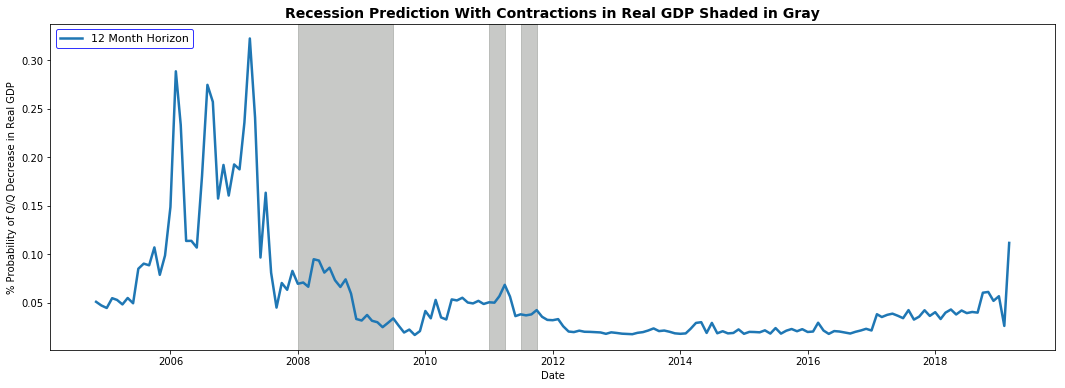

In [127]:
x = result1.index
a = result1.iloc[:,0]
b = result1.iloc[:,1]
c = result1.iloc[:,2]
d = result1.iloc[:,3]

fig, ax = plt.subplots(figsize=(18, 6))
#ax.plot(x, a, linewidth=2.5, zorder=2)
#ax.plot(x, b, linewidth=2.5, zorder=2)
#ax.plot(x, c, linewidth=2.5, zorder=2)
ax.plot(x, d, linewidth=2.5, zorder=2)
ax.scatter(x, d, s=0, zorder=1, label='_nolegend_')
ax.axvspan(x[38],x[56], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[74],x[77], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[80],x[83], color=sns.xkcd_rgb['grey'], alpha=0.5)

ax.set_title('Recession Prediction With Contractions in Real GDP Shaded in Gray', fontsize=14, fontweight='demi')

ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')

ax.set_ylabel('% Probability of Q/Q Decrease in Real GDP')
ax.set_xlabel('Date')

In [149]:
result1.tail()

,Current Month,1 Month Horizon,3 Month Horizon,12 Month Horizon
2018-11-01,0.020,0.022,0.044,0.061
2018-12-01,0.016,0.019,0.040,0.052
2019-01-01,0.041,0.036,0.059,0.057
2019-02-01,0.025,0.024,0.050,0.026
2019-03-01,0.054,0.035,0.064,0.112


In [128]:
y_shift = y.shift(-12) #needs to be negative to look forward
y_shift = y_shift.fillna(0)

In [129]:
X_train = X.iloc[12:550]
X_test = X.iloc[550:]
y_train = y_shift.iloc[12:550]
y_test = y_shift.iloc[550:]

In [130]:
model = xgb.XGBClassifier(learning_rate=0.005,
                                   n_estimators=1000, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=1,
                                   subsample=0.5)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.005, max_delta_step=0,
       max_depth=1, min_child_weight=1, min_samples_leaf=4, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

In [131]:
probs = model.predict_proba(X_test)

In [132]:
log_loss(y_test, probs)

0.4276454635825805

In [133]:
roc_auc_score(y_test.values, probs[:,1:])

0.7197986577181208

In [134]:
results = pd.DataFrame(probs)
results['actual'] = y_test.values
results.index = y_test.index
pd.set_option('display.float_format', lambda x: '%.3f' % x)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(results)

               0     1  actual
2004-11-01 0.949 0.051   0.000
2004-12-01 0.953 0.047   0.000
2005-01-01 0.956 0.044   0.000
2005-02-01 0.945 0.055   0.000
2005-03-01 0.947 0.053   0.000
2005-04-01 0.952 0.048   0.000
2005-05-01 0.945 0.055   0.000
2005-06-01 0.951 0.049   0.000
2005-07-01 0.915 0.085   0.000
2005-08-01 0.910 0.090   0.000
2005-09-01 0.912 0.088   0.000
2005-10-01 0.893 0.107   0.000
2005-11-01 0.921 0.079   0.000
2005-12-01 0.901 0.099   0.000
2006-01-01 0.851 0.149   0.000
2006-02-01 0.711 0.289   0.000
2006-03-01 0.767 0.233   0.000
2006-04-01 0.886 0.114   0.000
2006-05-01 0.886 0.114   0.000
2006-06-01 0.893 0.107   0.000
2006-07-01 0.820 0.180   0.000
2006-08-01 0.725 0.275   0.000
2006-09-01 0.743 0.257   0.000
2006-10-01 0.843 0.157   0.000
2006-11-01 0.808 0.192   0.000
2006-12-01 0.840 0.160   0.000
2007-01-01 0.807 0.193   1.000
2007-02-01 0.813 0.187   1.000
2007-03-01 0.764 0.236   1.000
2007-04-01 0.678 0.322   0.000
2007-05-01 0.759 0.241   0.000
2007-06-

In [135]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y)

1959-01-01   0.000
1959-02-01   0.000
1959-03-01   0.000
1959-04-01   0.000
1959-05-01   0.000
1959-06-01   0.000
1959-07-01   0.000
1959-08-01   0.000
1959-09-01   0.000
1959-10-01   0.000
1959-11-01   0.000
1959-12-01   0.000
1960-01-01   0.000
1960-02-01   0.000
1960-03-01   0.000
1960-04-01   1.000
1960-05-01   1.000
1960-06-01   1.000
1960-07-01   0.000
1960-08-01   0.000
1960-09-01   0.000
1960-10-01   1.000
1960-11-01   1.000
1960-12-01   1.000
1961-01-01   0.000
1961-02-01   0.000
1961-03-01   0.000
1961-04-01   0.000
1961-05-01   0.000
1961-06-01   0.000
1961-07-01   0.000
1961-08-01   0.000
1961-09-01   0.000
1961-10-01   0.000
1961-11-01   0.000
1961-12-01   0.000
1962-01-01   0.000
1962-02-01   0.000
1962-03-01   0.000
1962-04-01   0.000
1962-05-01   0.000
1962-06-01   0.000
1962-07-01   0.000
1962-08-01   0.000
1962-09-01   0.000
1962-10-01   0.000
1962-11-01   0.000
1962-12-01   0.000
1963-01-01   0.000
1963-02-01   0.000
1963-03-01   0.000
1963-04-01   0.000
1963-05-01  

In [136]:
print(sum(y))

84.0


In [137]:
X_train

,PMI,UNR,YUNR,CONS_SENT,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,...,3YRT_12m_shift,10 Year Treasury Yield_12m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_12m_shift,Spread_12m_shift,CPI_1m_shift,PPI_1m_shift,CPI_3m_shift,PPI_3m_shift,CPI_12m_shift,PPI_12m_shift
1960-01-01,58.200,5.300,11.100,93.800,1000.000,165.379,1331.173,1601.000,69.493,9.400,...,0.000,0.700,1.580,-0.880,0.000,0.000,0.341,-0.631,1.730,-0.316
1960-02-01,61.500,5.200,10.900,93.800,1015.000,165.379,1092.000,1460.000,69.493,10.100,...,0.000,0.530,1.300,-0.770,-0.340,0.317,-0.340,0.000,1.034,-0.315
1960-03-01,52.300,4.800,10.200,93.800,1062.000,165.379,1088.000,1503.000,69.493,11.000,...,0.000,0.260,0.520,-0.260,0.341,0.000,0.000,0.317,1.730,-0.315
1960-04-01,47.800,5.400,11.500,93.800,888.000,165.379,955.000,1109.000,69.493,10.900,...,0.000,0.160,0.290,-0.130,0.000,0.633,0.000,0.952,1.730,0.315
1960-05-01,45.300,5.200,10.900,93.300,1041.000,165.379,1016.000,1289.000,69.493,10.600,...,0.000,0.040,0.460,-0.420,0.340,0.000,0.683,0.633,1.724,0.000
1960-06-01,42.600,5.100,10.700,93.300,988.000,165.379,1052.000,1271.000,69.493,9.400,...,0.000,-0.190,-0.770,0.580,0.000,-0.314,0.340,0.316,1.724,-0.314
1960-07-01,44.400,5.400,11.000,93.300,966.000,165.379,958.000,1247.000,69.493,8.400,...,0.000,-0.500,-0.920,0.420,0.339,0.000,0.680,-0.314,1.718,0.000
1960-08-01,43.700,5.500,10.800,97.200,1013.000,165.379,999.000,1197.000,69.493,10.400,...,0.000,-0.630,-1.110,0.480,0.000,0.000,0.339,-0.314,1.370,0.000
1960-09-01,47.600,5.600,11.400,97.200,1018.000,165.379,994.000,1344.000,69.493,10.400,...,0.000,-0.880,-1.610,0.730,0.000,-0.315,0.339,-0.315,1.370,0.000
1960-10-01,45.400,5.500,11.000,97.200,1027.000,165.379,984.000,1097.000,69.493,10.400,...,0.000,-0.640,-1.800,1.160,0.000,0.000,0.000,-0.315,1.024,-0.315


In [138]:
model.feature_importances_

array([0.01748401, 0.01646847, 0.01593648, 0.01646094, 0.        ,
       0.01564574, 0.01953725, 0.01499907, 0.02151912, 0.        ,
       0.        , 0.        , 0.        , 0.01593164, 0.        ,
       0.        , 0.        , 0.        , 0.01664889, 0.01341062,
       0.01840581, 0.03070325, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01350124, 0.        , 0.        , 0.        , 0.01121031,
       0.01597555, 0.01390805, 0.01502905, 0.01320491, 0.01237457,
       0.        , 0.        , 0.01719856, 0.01638968, 0.01478406,
       0.01112896, 0.01637323, 0.01220312, 0.0136773 , 0.01458542,
       0.00951877, 0.        , 0.01597226, 0.        , 0.01622193,
       0.01280932, 0.01502351, 0.00959362, 0.01052414, 0.01493895,
       0.        , 0.01485747, 0.        , 0.01905795, 0.01414043,
       0.0138027 , 0.01727299, 0.01509658, 0.        , 0.01100305,
       0.        , 0.        , 0.        , 0.01723485, 0.     

In [139]:
for combo in zip(X_train.columns,model.feature_importances_):
    print(combo)

('PMI', 0.017484006)
('UNR', 0.016468465)
('YUNR', 0.015936475)
('CONS_SENT', 0.016460937)
('PART_TIME', 0.0)
('CPPR_PRICE', 0.015645739)
('HOUS_PERMS', 0.019537253)
('HOUS_STARTS', 0.014999074)
('CAP_UTIL', 0.021519117)
('PERS_SAVINGS', 0.0)
('EXPORTS', 0.0)
('IMPORTS', 0.0)
('TRADE_BALANCE', 0.0)
('INT_RATE', 0.015931642)
('US_M2', 0.0)
('US_NHOME_SALES', 0.0)
('PPI', 0.0)
('CPI', 0.0)
('3YRT', 0.016648887)
('10 Year Treasury Yield', 0.01341062)
('3 Month Treasury Yield (Bond Equivalent Basis)', 0.018405814)
('Spread', 0.03070325)
('CPPR_PRICE_PXY', 0.0)
('HOUS_PERMS_PXY', 0.0)
('HOUS_STARTS_PXY', 0.0)
('CAP_UTIL_PXY', 0.0)
('PERS_SAVINGS_PXY', 0.0)
('US_M2_PXY', 0.0)
('US_NHOME_SALES_PXY', 0.0)
('CPI_PXY', 0.0)
('PMI_1m_shift', 0.013501235)
('UNR_1m_shift', 0.0)
('YUNR_1m_shift', 0.0)
('CONS_SENT_1m_shift', 0.0)
('PART_TIME_1m_shift', 0.01121031)
('CPPR_PRICE_1m_shift', 0.015975548)
('HOUS_PERMS_1m_shift', 0.013908046)
('HOUS_STARTS_1m_shift', 0.0150290495)
('CAP_UTIL_1m_shift', 0.0

In [140]:
importance = pd.DataFrame(zip(X_train.columns,model.feature_importances_), columns = ['Indicator','Importance'])

In [141]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(importance.sort_values(['Importance'], ascending = False))

                                            Indicator  Importance
21                                             Spread       0.031
83                                 INT_RATE_12m_shift       0.026
8                                            CAP_UTIL       0.022
95                                      PPI_12m_shift       0.021
90                                       CPI_1m_shift       0.021
88  3 Month Treasury Yield (Bond Equivalent Basis)...       0.021
6                                          HOUS_PERMS       0.020
94                                      CPI_12m_shift       0.019
92                                       CPI_3m_shift       0.019
63                                  INT_RATE_3m_shift       0.019
85                           US_NHOME_SALES_12m_shift       0.019
20     3 Month Treasury Yield (Bond Equivalent Basis)       0.018
93                                       PPI_3m_shift       0.018
91                                       PPI_1m_shift       0.018
0         

In [142]:
X_train.head(100)

,PMI,UNR,YUNR,CONS_SENT,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,...,3YRT_12m_shift,10 Year Treasury Yield_12m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_12m_shift,Spread_12m_shift,CPI_1m_shift,PPI_1m_shift,CPI_3m_shift,PPI_3m_shift,CPI_12m_shift,PPI_12m_shift
1960-01-01,58.200,5.300,11.100,93.800,1000.000,165.379,1331.173,1601.000,69.493,9.400,...,0.000,0.700,1.580,-0.880,0.000,0.000,0.341,-0.631,1.730,-0.316
1960-02-01,61.500,5.200,10.900,93.800,1015.000,165.379,1092.000,1460.000,69.493,10.100,...,0.000,0.530,1.300,-0.770,-0.340,0.317,-0.340,0.000,1.034,-0.315
1960-03-01,52.300,4.800,10.200,93.800,1062.000,165.379,1088.000,1503.000,69.493,11.000,...,0.000,0.260,0.520,-0.260,0.341,0.000,0.000,0.317,1.730,-0.315
1960-04-01,47.800,5.400,11.500,93.800,888.000,165.379,955.000,1109.000,69.493,10.900,...,0.000,0.160,0.290,-0.130,0.000,0.633,0.000,0.952,1.730,0.315
1960-05-01,45.300,5.200,10.900,93.300,1041.000,165.379,1016.000,1289.000,69.493,10.600,...,0.000,0.040,0.460,-0.420,0.340,0.000,0.683,0.633,1.724,0.000
1960-06-01,42.600,5.100,10.700,93.300,988.000,165.379,1052.000,1271.000,69.493,9.400,...,0.000,-0.190,-0.770,0.580,0.000,-0.314,0.340,0.316,1.724,-0.314
1960-07-01,44.400,5.400,11.000,93.300,966.000,165.379,958.000,1247.000,69.493,8.400,...,0.000,-0.500,-0.920,0.420,0.339,0.000,0.680,-0.314,1.718,0.000
1960-08-01,43.700,5.500,10.800,97.200,1013.000,165.379,999.000,1197.000,69.493,10.400,...,0.000,-0.630,-1.110,0.480,0.000,0.000,0.339,-0.314,1.370,0.000
1960-09-01,47.600,5.600,11.400,97.200,1018.000,165.379,994.000,1344.000,69.493,10.400,...,0.000,-0.880,-1.610,0.730,0.000,-0.315,0.339,-0.315,1.370,0.000
1960-10-01,45.400,5.500,11.000,97.200,1027.000,165.379,984.000,1097.000,69.493,10.400,...,0.000,-0.640,-1.800,1.160,0.000,0.000,0.000,-0.315,1.024,-0.315


In [143]:
X = X.iloc[12:]
y = y.iloc[12:]

In [144]:
tscv = TimeSeriesSplit(n_splits=4)

In [145]:
TimeSeriesSplit(max_train_size=None, n_splits=4)

TimeSeriesSplit(max_train_size=None, n_splits=4)

In [146]:
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #print(X_train, y_train)
    
    
    model = xgb.XGBClassifier(learning_rate=0.005,
                                   n_estimators=1000, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=1,
                                   subsample=0.5)

    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)
    
    #print(probs)
    
    print(log_loss(y_test, probs))
    
    print(roc_auc_score(y_test.values, probs[:,1:]))
    
    results = pd.DataFrame(probs)
    results['actual'] = y_test.values
    results.index = y_test.index
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(results)
    

0.32388074735415656
0.9077008618293021
               0     1  actual
1971-12-01 0.953 0.047   0.000
1972-01-01 0.968 0.032   0.000
1972-02-01 0.976 0.024   0.000
1972-03-01 0.971 0.029   0.000
1972-04-01 0.974 0.026   0.000
1972-05-01 0.973 0.027   0.000
1972-06-01 0.972 0.028   0.000
1972-07-01 0.971 0.029   0.000
1972-08-01 0.981 0.019   0.000
1972-09-01 0.982 0.018   0.000
1972-10-01 0.976 0.024   0.000
1972-11-01 0.975 0.025   0.000
1972-12-01 0.981 0.019   0.000
1973-01-01 0.972 0.028   0.000
1973-02-01 0.936 0.064   0.000
1973-03-01 0.906 0.094   0.000
1973-04-01 0.934 0.066   0.000
1973-05-01 0.852 0.148   0.000
1973-06-01 0.927 0.073   0.000
1973-07-01 0.873 0.127   1.000
1973-08-01 0.499 0.501   1.000
1973-09-01 0.613 0.387   1.000
1973-10-01 0.529 0.471   0.000
1973-11-01 0.714 0.286   0.000
1973-12-01 0.636 0.364   0.000
1974-01-01 0.568 0.432   1.000
1974-02-01 0.323 0.677   1.000
1974-03-01 0.259 0.741   1.000
1974-04-01 0.566 0.434   0.000
1974-05-01 0.638 0.362   0.000


0.11284659206736046
0.9705882352941176
               0     1  actual
1995-08-01 0.975 0.025   0.000
1995-09-01 0.980 0.020   0.000
1995-10-01 0.981 0.019   0.000
1995-11-01 0.972 0.028   0.000
1995-12-01 0.970 0.030   0.000
1996-01-01 0.972 0.028   0.000
1996-02-01 0.931 0.069   0.000
1996-03-01 0.973 0.027   0.000
1996-04-01 0.972 0.028   0.000
1996-05-01 0.985 0.015   0.000
1996-06-01 0.977 0.023   0.000
1996-07-01 0.985 0.015   0.000
1996-08-01 0.979 0.021   0.000
1996-09-01 0.982 0.018   0.000
1996-10-01 0.981 0.019   0.000
1996-11-01 0.977 0.023   0.000
1996-12-01 0.979 0.021   0.000
1997-01-01 0.976 0.024   0.000
1997-02-01 0.978 0.022   0.000
1997-03-01 0.986 0.014   0.000
1997-04-01 0.986 0.014   0.000
1997-05-01 0.983 0.017   0.000
1997-06-01 0.983 0.017   0.000
1997-07-01 0.977 0.023   0.000
1997-08-01 0.985 0.015   0.000
1997-09-01 0.985 0.015   0.000
1997-10-01 0.986 0.014   0.000
1997-11-01 0.986 0.014   0.000
1997-12-01 0.986 0.014   0.000
1998-01-01 0.981 0.019   0.000


In [147]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y)

1960-01-01   0.000
1960-02-01   0.000
1960-03-01   0.000
1960-04-01   1.000
1960-05-01   1.000
1960-06-01   1.000
1960-07-01   0.000
1960-08-01   0.000
1960-09-01   0.000
1960-10-01   1.000
1960-11-01   1.000
1960-12-01   1.000
1961-01-01   0.000
1961-02-01   0.000
1961-03-01   0.000
1961-04-01   0.000
1961-05-01   0.000
1961-06-01   0.000
1961-07-01   0.000
1961-08-01   0.000
1961-09-01   0.000
1961-10-01   0.000
1961-11-01   0.000
1961-12-01   0.000
1962-01-01   0.000
1962-02-01   0.000
1962-03-01   0.000
1962-04-01   0.000
1962-05-01   0.000
1962-06-01   0.000
1962-07-01   0.000
1962-08-01   0.000
1962-09-01   0.000
1962-10-01   0.000
1962-11-01   0.000
1962-12-01   0.000
1963-01-01   0.000
1963-02-01   0.000
1963-03-01   0.000
1963-04-01   0.000
1963-05-01   0.000
1963-06-01   0.000
1963-07-01   0.000
1963-08-01   0.000
1963-09-01   0.000
1963-10-01   0.000
1963-11-01   0.000
1963-12-01   0.000
1964-01-01   0.000
1964-02-01   0.000
1964-03-01   0.000
1964-04-01   0.000
1964-05-01  